In [67]:
%%capture
# Install required libraries
!pip install -q git+https://github.com/openai/whisper.git
!pip install -q git+https://github.com/librosa/librosa
!pip install -q soundfile

import torch
import whisper
import librosa
import matplotlib.pyplot as plt
import numpy as np
import IPython.display as ipd
import soundfile as sf
from urllib.request import urlretrieve
import os
import warnings

# Initial settings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

In [68]:
class SpeechProcessor:
    def __init__(self, model_size="medium"):
        """
        Initialize the speech processor
        :param model_size: Whisper model size (tiny, base, small, medium, large)
        """
        self.model_size = model_size
        self.model = None
        self.audio = None
        self.sample_rate = 16000  # Whisper's default sample rate

    def load_model(self):
        """Load Whisper model"""
        print(f"Loading {self.model_size} model...")
        self.model = whisper.load_model(self.model_size)
        print("Model loaded successfully.")

    def load_audio(self, audio_path, is_url=False):
        """
        Load audio file
        :param audio_path: Path to audio file or URL
        :param is_url: If True, audio_path is treated as URL
        """
        try:
            if is_url:
                print("Downloading audio file...")
                local_path = "temp_audio.mp3"
                urlretrieve(audio_path, local_path)
                audio_path = local_path

            print("Processing audio file...")
            self.audio = whisper.load_audio(audio_path)
            self.sample_rate = librosa.get_samplerate(audio_path)

            if is_url:
                os.remove(local_path)

            return True
        except Exception as e:
            print(f"Error loading audio file: {e}")
            return False

    def plot_audio(self, segment=None):
        """Plot audio waveform"""
        if self.audio is None:
            print("No audio file loaded.")
            return

        audio_to_plot = self.audio if segment is None else segment
        duration = len(audio_to_plot) / self.sample_rate
        time = np.linspace(0, duration, len(audio_to_plot))

        plt.figure(figsize=(12, 4))
        plt.plot(time, audio_to_plot)
        plt.title('Audio Waveform')
        plt.ylabel('Amplitude')
        plt.xlabel('Time (seconds)')
        plt.grid(True)
        plt.show()

    def play_audio(self, segment=None):
        """Play audio"""
        if self.audio is None:
            print("No audio file loaded.")
            return

        audio_to_play = self.audio if segment is None else segment
        ipd.display(ipd.Audio(audio_to_play, rate=self.sample_rate))

    def analyze_audio(self):
        """Analyze audio and display spectrogram"""
        if self.audio is None:
            print("No audio file loaded.")
            return

        # Audio preprocessing
        audio = whisper.pad_or_trim(self.audio)
        mel = whisper.log_mel_spectrogram(audio).to(self.model.device)

        # Visualization
        duration = len(audio) / self.sample_rate
        time = np.linspace(0, duration, len(audio))

        fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 8))
        fig.tight_layout(pad=3.0)

        # Time-domain plot
        ax1.plot(time, audio)
        ax1.set_title('Audio Waveform')
        ax1.set_xlabel('Time (seconds)')
        ax1.set_ylabel('Amplitude')
        ax1.grid(True)

        # Spectrogram
        ax2.imshow((mel.numpy()*mel.numpy())**(1/2),
                  interpolation='nearest',
                  aspect='auto',
                  origin='lower')
        ax2.set_title('Mel-Spectrogram')
        ax2.set_xlabel('Time (seconds)')
        ax2.set_ylabel('Frequency (Mel Scale)')

        plt.show()

    def detect_language(self):
        """Detect spoken language"""
        if self.model is None:
            print("Model not loaded.")
            return None

        if self.audio is None:
            print("No audio file loaded.")
            return None

        audio = whisper.pad_or_trim(self.audio)
        mel = whisper.log_mel_spectrogram(audio).to(self.model.device)

        _, probs = self.model.detect_language(mel)
        detected_lang = max(probs, key=probs.get)

        print("Detected language probabilities:")
        for lang, prob in sorted(probs.items(), key=lambda x: x[1], reverse=True)[:5]:
            print(f"{lang}: {prob:.2f}")

        print(f"\nPrimary detected language: {detected_lang}")
        return detected_lang

    def transcribe(self, language=None):
        """
        Transcribe speech to text
        :param language: Input language (if None, auto-detects)
        """
        if self.model is None or self.audio is None:
            print("Model or audio file not loaded.")
            return None

        options = whisper.DecodingOptions(
            fp16=False,
            language=language
        )

        audio = whisper.pad_or_trim(self.audio)
        mel = whisper.log_mel_spectrogram(audio).to(self.model.device)
        result = whisper.decode(self.model, mel, options)

        print("\nTranscription results:")
        print(result.text)
        return result.text

    def translate(self, target_language='en'):
        """
        Translate speech to target language
        :param target_language: Target language (default: English)
        """
        if self.model is None or self.audio is None:
            print("Model or audio file not loaded.")
            return None

        result = self.model.transcribe(
            self.audio,
            fp16=False,
            language=target_language
        )

        print("\nTranslation results:")
        print(result['text'])
        return result['text']

Loading medium model...
Model loaded successfully.
Processing audio file...


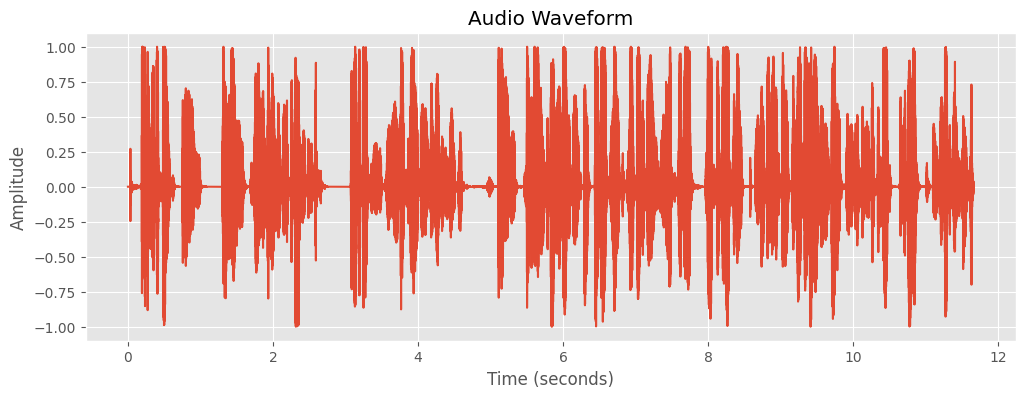

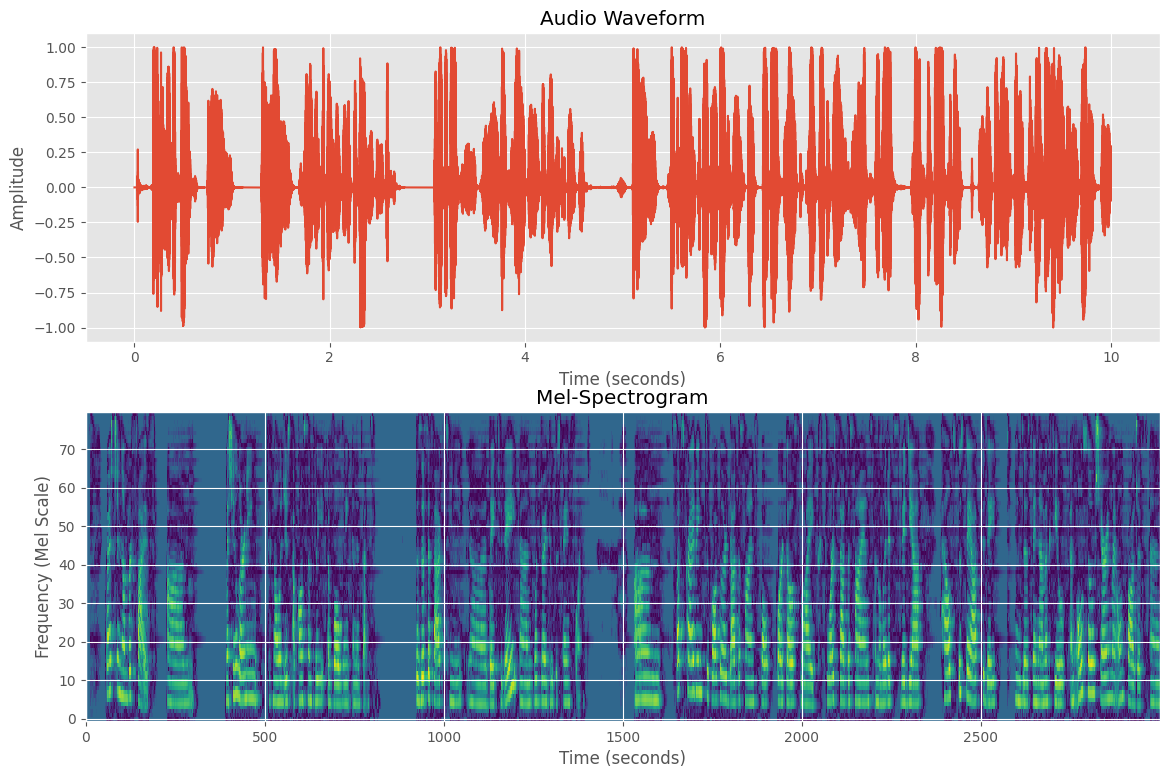

Detected language probabilities:
en: 1.00
pl: 0.00
cy: 0.00
ru: 0.00
ko: 0.00

Primary detected language: en

Transcription results:
Question number five. Machine learning technologies are constantly evolving and advancing. Does this affect me day to day and what do I do to stay informed? Subscribing to popular data science portals like Towards Data Science, Analytics, Vidya helps to stay up to date in this dynamic field and also sharing

Translation results:
 Question number five. Machine learning technologies are constantly evolving and advancing. Does this affect me day to day and what do I do to stay informed? Subscribing to popular data science portals like Towards Data Science, Analytics, Vidya helps to stay up to date in this dynamic field and also sharing my own projects and receiving some feedback from the public expands my data science knowledge.


In [69]:
# Example usage
if __name__ == "__main__":
    # Sample audio URL (replace with your own)
    AUDIO_URL = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-GPXX0EPMEN/20220627_140242.mp4"

    # Create processor instance
    processor = SpeechProcessor(model_size="medium")

    # Load model
    processor.load_model()

    # Load audio from URL
    if processor.load_audio(AUDIO_URL, is_url=True):
        # Visualize and play audio
        processor.plot_audio()
        processor.play_audio()

        # Analyze audio
        processor.analyze_audio()

        # Detect language
        processor.detect_language()

        # Transcribe speech
        transcription = processor.transcribe()

        # Translate to English
        translation = processor.translate(target_language='en')